In [2]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.metrics.pairwise import pairwise_distances_argmin
import warnings

In [3]:
# 设置在jupyter中matplotlib的显示情况（默认inline是内嵌显示，通过设置为tk表示不内嵌显示）
# %matplotlib tk

In [4]:
def expand(a, b):
    return 1.05*a-0.05*b, 1.05*b-0.05*a

In [5]:
warnings.filterwarnings("ignore")   # hmmlearn(0.2.0) < sklearn(0.18)
np.random.seed(28)
n = 5   # 隐状态数目
n_samples = 500 # 样本数量

In [6]:
pi = np.random.rand(n)
pi /= pi.sum()
print('初始概率：')
print(pi)

初始概率：
[0.28102534 0.21635059 0.04817319 0.1532667  0.30118418]


In [7]:
A = np.random.rand(n, n)
mask = np.zeros((n, n), dtype=np.bool)
mask[0][1] = mask[0][4] = True
mask[1][0] = mask[1][2] = True
mask[2][1] = mask[2][3] = True
mask[3][2] = mask[3][4] = True
mask[4][0] = mask[4][3] = True
A[mask] = 0
for i in range(n):
    A[i] /= A[i].sum()
print('转移概率:')
print(A)


转移概率:
[[0.2202672  0.         0.36791287 0.41181993 0.        ]
 [0.         0.4995834  0.         0.01356202 0.48685458]
 [0.57655791 0.         0.10400763 0.         0.31943446]
 [0.23695178 0.33043766 0.         0.43261056 0.        ]
 [0.         0.58044648 0.15883558 0.         0.26071794]]


In [8]:
# 给定均值
means = np.array(((30, 30, 30), (0, 50, 20), (-25, 30, 10), (-15, 0, 25), (15, 0, 40)), dtype=np.float)
for i in range(n):
    means[i,:] /= np.sqrt(np.sum(means ** 2, axis=1))[i]
print('均值：')
print(means)

均值：
[[ 0.57735027  0.57735027  0.57735027]
 [ 0.          0.92847669  0.37139068]
 [-0.62017367  0.74420841  0.24806947]
 [-0.51449576  0.          0.85749293]
 [ 0.35112344  0.          0.93632918]]


In [9]:
# 给定方差
covars = np.empty((n, 3, 3))
for i in range(n):
    covars[i] = np.diag(np.random.rand(3)*0.02+0.001)    # np.random.rand ∈[0,1)
print('方差：\n')
print(covars)

方差：

[[[0.0155071  0.         0.        ]
  [0.         0.02010293 0.        ]
  [0.         0.         0.00246192]]

 [[0.00994326 0.         0.        ]
  [0.         0.01782236 0.        ]
  [0.         0.         0.00391079]]

 [[0.01630543 0.         0.        ]
  [0.         0.0166357  0.        ]
  [0.         0.         0.01450157]]

 [[0.00363404 0.         0.        ]
  [0.         0.00178606 0.        ]
  [0.         0.         0.01412046]]

 [[0.00602365 0.         0.        ]
  [0.         0.02076837 0.        ]
  [0.         0.         0.01166766]]]


In [10]:
# 产生对应的模拟数据
model = hmm.GaussianHMM(n_components=n, covariance_type='full')
model.startprob_ = pi
model.transmat_ = A
model.means_ = means
model.covars_ = covars
sample, labels = model.sample(n_samples=n_samples, random_state=0)

In [11]:
# 模型构建及估计参数
model = hmm.GaussianHMM(n_components=n, covariance_type='full', n_iter=10)
model.fit(sample)
y = model.predict(sample)
np.set_printoptions(suppress=True)
print('##估计初始概率：')
print(model.startprob_)
print('##估计转移概率：')
print(model.transmat_)
print('##估计均值：\n')
print(model.means_)
print('##估计方差：\n')
print(model.covars_)

##估计初始概率：
[0. 0. 1. 0. 0.]
##估计转移概率：
[[0.53070356 0.45175252 0.01754392 0.         0.        ]
 [0.61038447 0.22727269 0.         0.16234284 0.        ]
 [0.31707317 0.         0.48780488 0.         0.19512195]
 [0.         0.39536037 0.         0.11627698 0.48836266]
 [0.         0.         0.48484889 0.39393889 0.12121222]]
##估计均值：

[[-0.00362742  0.92283229  0.37226363]
 [ 0.34487731 -0.00195664  0.93881753]
 [-0.5168573   0.00094903  0.85695108]
 [-0.66623282  0.72555432  0.24210984]
 [ 0.55697474  0.62964013  0.5667117 ]]
##估计方差：

[[[ 0.00893018 -0.00036242  0.00004194]
  [-0.00036242  0.0146526   0.00006488]
  [ 0.00004194  0.00006488  0.00340065]]

 [[ 0.00580409 -0.0000912   0.00069388]
  [-0.0000912   0.02026833 -0.0012663 ]
  [ 0.00069388 -0.0012663   0.01309224]]

 [[ 0.00341816 -0.0004482   0.00132588]
  [-0.0004482   0.00196013  0.00027713]
  [ 0.00132588  0.00027713  0.01525896]]

 [[ 0.01673939 -0.00116631 -0.00104601]
  [-0.00116631  0.01308765 -0.00160787]
  [-0.001046

In [12]:
# 根据类别信息更改顺序
order = pairwise_distances_argmin(means, model.means_, metric='euclidean')
print(order)
pi_hat = model.startprob_[order]
A_hat = model.transmat_[order]
A_hat = A_hat[:, order]
means_hat = model.means_[order]
covars_hat = model.covars_[order]
change = np.empty((n, n_samples), dtype=np.bool)
for i in range(n):
    change[i] = y == order[i]
for i in range(n):
    y[change[i]] = i
print('估计初始概率：')
print(pi_hat)
print('估计转移概率：')
print(A_hat)
print('估计均值：')
print(means_hat)
print('估计方差：')
print(covars_hat)
print(labels)
print(y)
acc = np.mean(labels == y) * 100
print('准确率：%.2f%%' % acc)


[4 0 3 2 1]
估计初始概率：
[0. 0. 0. 1. 0.]
估计转移概率：
[[0.12121222 0.         0.39393889 0.48484889 0.        ]
 [0.         0.53070356 0.         0.01754392 0.45175252]
 [0.48836266 0.         0.11627698 0.         0.39536037]
 [0.19512195 0.31707317 0.         0.48780488 0.        ]
 [0.         0.61038447 0.16234284 0.         0.22727269]]
估计均值：
[[ 0.55697474  0.62964013  0.5667117 ]
 [-0.00362742  0.92283229  0.37226363]
 [-0.66623282  0.72555432  0.24210984]
 [-0.5168573   0.00094903  0.85695108]
 [ 0.34487731 -0.00195664  0.93881753]]
估计方差：
[[[ 0.01625931 -0.00100449 -0.00019992]
  [-0.00100449  0.01590626 -0.00121909]
  [-0.00019992 -0.00121909  0.00207361]]

 [[ 0.00893018 -0.00036242  0.00004194]
  [-0.00036242  0.0146526   0.00006488]
  [ 0.00004194  0.00006488  0.00340065]]

 [[ 0.01673939 -0.00116631 -0.00104601]
  [-0.00116631  0.01308765 -0.00160787]
  [-0.00104601 -0.00160787  0.01618941]]

 [[ 0.00341816 -0.0004482   0.00132588]
  [-0.0004482   0.00196013  0.00027713]
  [ 0.0013

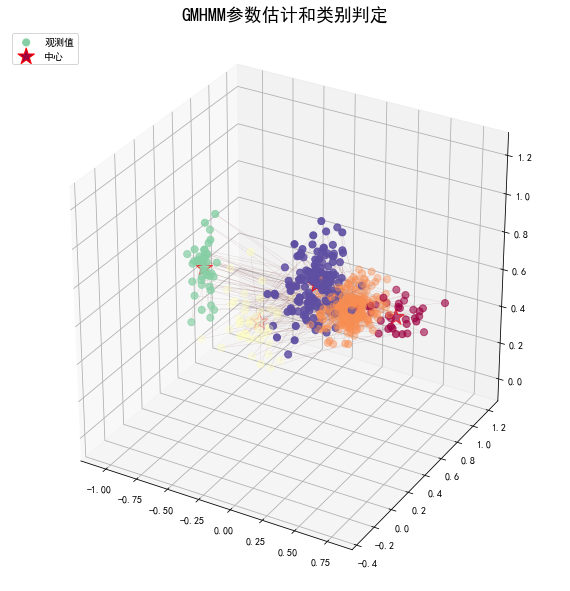

In [13]:
# 画图
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(8, 8), facecolor='w')
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.Spectral(np.linspace(0,1,n))
ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2], s=50, c=labels, cmap=plt.cm.Spectral, marker='o', label=u'观测值', depthshade=True)
plt.plot(sample[:, 0], sample[:, 1], sample[:, 2], lw=0.1, color='#A07070')
colors = plt.cm.Spectral(np.linspace(0, 1, n))
ax.scatter(means[:, 0], means[:, 1], means[:, 2], s=300, c=colors, edgecolor='r', linewidths=1, marker='*', label=u'中心')

x_min, y_min, z_min = sample.min(axis=0)
x_max, y_max, z_max = sample.max(axis=0)
x_min, x_max = expand(x_min, x_max)
y_min, y_max = expand(y_min, y_max)
z_min, z_max = expand(z_min, z_max)
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.set_zlim((z_min, z_max))
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout(1)
plt.title(u'GMHMM参数估计和类别判定', fontsize=18)
plt.show()